# Setup

## Imports, gdrive

In [ ]:
from tensorflow.python.ops.gen_math_ops import truncate_mod
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from ResNet import *
from InceptionNet import *

from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import activations
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model 


from pathlib import Path 
!pip install -q -U tensorflow-addons

import tensorflow_addons as tfa

from google.colab import drive
from pathlib import Path 
mnt = Path('/content/drive')
drive.mount(str(mnt))

mydrive = Path(mnt) / 'MyDrive' / 'Colab Notebooks' / 'DL for Optical Imaging' / 'Project'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
mydrive

PosixPath('/content/drive/MyDrive/Colab Notebooks/DL for Optical Imaging/Project')

In [ ]:
!nvidia-smi

Sun May 29 16:39:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def load(filename, key=None):
    # use a context manager
    # to avoid leaks
    with np.load(filename) as data:
        if not key:
            print(f'The keys are {list(data.keys())}.')
            return
        else:
            return data[key]

NClass        = 49


filename = mydrive / 'audVisIdn.npz'

## Data Setup

In [ ]:
import tensorflow as tf 
import tensorflow_addons as tfa
from pathlib import Path
import numpy as np 
import matplotlib.pyplot as plt 
SMALL = 0


class dataHolder():
  def __init__(self, directory=Path(mydrive), to_cat=False):
    self.prepareData(directory)
                      
  def prepareData(self, directory):
    ADD = '_64' if SMALL else '_160'
    self.trainlabels = np.load(directory / f'train_lab_faces_only{ADD}.npy')
    self.vallabels = np.load(directory / f'val_lab_faces_only{ADD}.npy')
    self.testlabels =  np.load(directory / f'test_lab_faces_only{ADD}.npy')
    # ~ 5 gigs RAM overall
    self.trainimg = np.load(directory / f'train_faces_only{ADD}.npy')
    self.valimg = np.load(directory / f'val_faces_only{ADD}.npy')
    self.testimg =  np.load(directory / f'test_faces_only{ADD}.npy')

  def getImagesFromPerson(self, label, dataset='train'):
    if dataset=='train':
        img = self.trainimg; lab = self.trainlabels
    elif dataset=='val':
        img = self.valimg; lab = self.vallabels
    elif dataset=='test':
        img = self.testimg; lab = self.testlabels
    relevant = np.where(lab == label)[0]
    imgs = [img[i,:,:,:] for i in relevant]
    return imgs
          
  def seeImageFromPerson(self, label, dataset='train', limit=5):
    imgs = self.getImagesFromPerson(label, dataset)
    count = 0
    for i  in range(len(imgs)):
        plt.figure(); plt.imshow(imgs[i])
        plt.waitforbuttonpress()
        count += 1
        if count >= limit:
            break

data = dataHolder()

train_out = tf.keras.utils.to_categorical(data.trainlabels, 49)
val_out = tf.keras.utils.to_categorical(data.vallabels, 49)
test_out = tf.keras.utils.to_categorical(data.testlabels, 49)

# Network

## Inception ResNet

In [ ]:
import tensorflow.compat.v2 as tf

from keras import backend
from keras.applications import imagenet_utils
from keras.engine import training
from keras.layers import VersionAwareLayers
from keras.utils import data_utils
from keras.utils import layer_utils


BASE_WEIGHT_URL = ('https://storage.googleapis.com/tensorflow/'
                   'keras-applications/inception_resnet_v2/')
layers = None


def InceptionResNetV2(include_top=True,
                      weights='imagenet',
                      input_tensor=None,
                      input_shape=None,
                      pooling=None,
                      classes=1000,
                      classifier_activation='softmax',
                      **kwargs):
  global layers
  if 'layers' in kwargs:
    layers = kwargs.pop('layers')
  else:
    layers = VersionAwareLayers()
  if kwargs:
    raise ValueError('Unknown argument(s): %s' % (kwargs,))
  if not (weights in {'imagenet', None} or tf.io.gfile.exists(weights)):
    raise ValueError('The `weights` argument should be either '
                     '`None` (random initialization), `imagenet` '
                     '(pre-training on ImageNet), '
                     'or the path to the weights file to be loaded.')

  if weights == 'imagenet' and include_top and classes != 1000:
    raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                     ' as true, `classes` should be 1000')

  # Determine proper input shape
  input_shape = imagenet_utils.obtain_input_shape(
      input_shape,
      default_size=299,
      min_size=75,
      data_format=backend.image_data_format(),
      require_flatten=include_top,
      weights=weights)

  if input_tensor is None:
    img_input = layers.Input(shape=input_shape)
  else:
    if not backend.is_keras_tensor(input_tensor):
      img_input = layers.Input(tensor=input_tensor, shape=input_shape)
    else:
      img_input = input_tensor

  # Stem block: 35 x 35 x 192
  x = conv2d_bn(img_input, 32, 3, strides=2, padding='valid')
  x = conv2d_bn(x, 32, 3, padding='valid')
  # x = conv2d_bn(x, 64, 3)
  x = layers.MaxPooling2D(3, strides=2)(x)
  x = conv2d_bn(x, 80, 1, padding='valid')
  x = conv2d_bn(x, 192, 3, padding='valid')
  x = layers.MaxPooling2D(3, strides=2)(x)

  # Mixed 5b (Inception-A block): 35 x 35 x 320
  branch_0 = conv2d_bn(x, 96, 1)
  branch_1 = conv2d_bn(x, 48, 1)
  branch_1 = conv2d_bn(branch_1, 64, 5)
  branch_2 = conv2d_bn(x, 64, 1)
  # branch_2 = conv2d_bn(branch_2, 96, 3)
  branch_2 = conv2d_bn(branch_2, 96, 3)
  branch_pool = layers.AveragePooling2D(3, strides=1, padding='same')(x)
  branch_pool = conv2d_bn(branch_pool, 64, 1)
  branches = [branch_0, branch_1, branch_2, branch_pool]
  channel_axis = 1 if backend.image_data_format() == 'channels_first' else 3
  x = layers.Concatenate(axis=channel_axis, name='mixed_5b')(branches)

  # 2x block35 (Inception-ResNet-A block): 35 x 35 x 320
  for block_idx in range(1, 3):
    x = inception_resnet_block(
        x, scale=0.17, block_type='block35', block_idx=block_idx)

  # Mixed 6a (Reduction-A block): 17 x 17 x 1088
  branch_0 = conv2d_bn(x, 384, 3, strides=2, padding='valid')
  branch_1 = conv2d_bn(x, 256, 1)
  # branch_1 = conv2d_bn(branch_1, 256, 3)
  branch_1 = conv2d_bn(branch_1, 384, 3, strides=2, padding='valid')
  branch_pool = layers.MaxPooling2D(3, strides=2, padding='valid')(x)
  branches = [branch_0, branch_1, branch_pool]
  x = layers.Concatenate(axis=channel_axis, name='mixed_6a')(branches)

  # 2x block17 (Inception-ResNet-B block): 17 x 17 x 1088
  for block_idx in range(1, 3):
    x = inception_resnet_block(
        x, scale=0.1, block_type='block17', block_idx=block_idx)

  # Mixed 7a (Reduction-B block): 8 x 8 x 2080
  branch_0 = conv2d_bn(x, 256, 1)
  branch_0 = conv2d_bn(branch_0, 384, 3, strides=2, padding='valid')
  branch_1 = conv2d_bn(x, 256, 1)
  branch_1 = conv2d_bn(branch_1, 288, 3, strides=2, padding='valid')
  branch_2 = conv2d_bn(x, 256, 1)
  # branch_2 = conv2d_bn(branch_2, 288, 3)
  branch_2 = conv2d_bn(branch_2, 320, 3, strides=2, padding='valid')
  branch_pool = layers.MaxPooling2D(3, strides=2, padding='valid')(x)
  branches = [branch_0, branch_1, branch_2, branch_pool]
  x = layers.Concatenate(axis=channel_axis, name='mixed_7a')(branches)

  # 2x block8 (Inception-ResNet-C block): 8 x 8 x 2080
  for block_idx in range(1, 3):
    x = inception_resnet_block(
        x, scale=0.2, block_type='block8', block_idx=block_idx)
  x = inception_resnet_block(
      x, scale=1., activation=None, block_type='block8', block_idx=10)

  # Final convolution block: 8 x 8 x 1536
  x = conv2d_bn(x, 1536, 1, name='conv_7b')

  if include_top:
    # Classification block
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    imagenet_utils.validate_activation(classifier_activation, weights)
    x = layers.Dense(classes, activation=classifier_activation,
                     name='predictions')(x)
  else:
    if pooling == 'avg':
      x = layers.GlobalAveragePooling2D()(x)
    elif pooling == 'max':
      x = layers.GlobalMaxPooling2D()(x)

  # Ensure that the model takes into account
  # any potential predecessors of `input_tensor`.
  if input_tensor is not None:
    inputs = layer_utils.get_source_inputs(input_tensor)
  else:
    inputs = img_input

  # Create model.
  model = training.Model(inputs, x, name='inception_resnet_v2')

  # Load weights.
  if weights == 'imagenet':
    if include_top:
      fname = 'inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5'
      weights_path = data_utils.get_file(
          fname,
          BASE_WEIGHT_URL + fname,
          cache_subdir='models',
          file_hash='e693bd0210a403b3192acc6073ad2e96')
    else:
      fname = ('inception_resnet_v2_weights_'
               'tf_dim_ordering_tf_kernels_notop.h5')
      weights_path = data_utils.get_file(
          fname,
          BASE_WEIGHT_URL + fname,
          cache_subdir='models',
          file_hash='d19885ff4a710c122648d3b5c3b684e4')
    model.load_weights(weights_path)
  elif weights is not None:
    model.load_weights(weights)

  return model


def conv2d_bn(x,
              filters,
              kernel_size,
              strides=1,
              padding='same',
              activation='relu',
              use_bias=False,
              name=None):

  x = layers.SeparableConv2D(
      filters,
      kernel_size,
      strides=strides,
      padding=padding,
      use_bias=use_bias,
      name=name)(
          x)
  if not use_bias:
    bn_axis = 1 if backend.image_data_format() == 'channels_first' else 3
    bn_name = None if name is None else name + '_bn'
    x = layers.BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)
  if activation is not None:
    ac_name = None if name is None else name + '_ac'
    x = layers.Activation(activation, name=ac_name)(x)
  return x


def inception_resnet_block(x, scale, block_type, block_idx, activation='relu'):

  if block_type == 'block35':
    branch_0 = conv2d_bn(x, 32, 1)
    branch_1 = conv2d_bn(x, 32, 1)
    branch_1 = conv2d_bn(branch_1, 32, 3)
    branch_2 = conv2d_bn(x, 32, 1)
    # branch_2 = conv2d_bn(branch_2, 48, 3)
    branch_2 = conv2d_bn(branch_2, 64, 3)
    branches = [branch_0, branch_1, branch_2]
  elif block_type == 'block17':
    branch_0 = conv2d_bn(x, 192, 1)
    branch_1 = conv2d_bn(x, 128, 1)
    # branch_1 = conv2d_bn(branch_1, 160, [1, 7])
    branch_1 = conv2d_bn(branch_1, 192, [7, 1])
    branches = [branch_0, branch_1]
  elif block_type == 'block8':
    branch_0 = conv2d_bn(x, 192, 1)
    branch_1 = conv2d_bn(x, 192, 1)
    # branch_1 = conv2d_bn(branch_1, 224, [1, 3])
    branch_1 = conv2d_bn(branch_1, 256, [3, 1])
    branches = [branch_0, branch_1]
  else:
    raise ValueError('Unknown Inception-ResNet block type. '
                     'Expects "block35", "block17" or "block8", '
                     'but got: ' + str(block_type))

  block_name = block_type + '_' + str(block_idx)
  channel_axis = 1 if backend.image_data_format() == 'channels_first' else 3
  mixed = layers.Concatenate(
      axis=channel_axis, name=block_name + '_mixed')(
          branches)
  up = conv2d_bn(
      mixed,
      backend.int_shape(x)[channel_axis],
      1,
      activation=None,
      use_bias=True,
      name=block_name + '_conv')

  x = layers.Lambda(
      lambda inputs, scale: inputs[0] + inputs[1] * scale,
      output_shape=backend.int_shape(x)[1:],
      arguments={'scale': scale},
      name=block_name)([x, up])
  if activation is not None:
    x = layers.Activation(activation, name=block_name + '_ac')(x)
  return x

In [ ]:
shape = (160,160,3)
def get_inception(InceptionResNetV2):
  model = InceptionResNetV2(include_top=1,
                            weights=None,#"imagenet",
                            input_tensor=None,
                            input_shape=shape,
                            pooling=None,
                            classes=49,
                            classifier_activation="softmax")

  # add some dropout at the end:
  l2 = model.layers[-3]
  l1 = model.layers[-2]
  output = model.layers[-1]

  dropout1 = tf.keras.layers.Dropout(0.7)
  dropout2 = tf.keras.layers.Dropout(0.5)

  x = dropout1(l2.output)
  x = l1(x)
  x = dropout2(x)
  outputdrop = output(x)

  modeldrop = Model(inputs=model.input, outputs=outputdrop)
  return modeldrop

In [ ]:
model = get_inception(InceptionResNetV2)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 separable_conv2d (SeparableCon  (None, 79, 79, 32)  123         ['input_1[0][0]']                
 v2D)                                                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 79, 79, 32)  96          ['separable_conv2d[0][0]']       
 alization)                                                                                   

## Compile the network

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=loss,
              metrics=['accuracy'])

# Training

## Data Augmentation (done on the fly)

### The generator

In [ ]:
batch_size = 100
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                          horizontal_flip=True,
                                                          #vertical_flip=True,
                                                          #zoom_range=[0.97,1.03],
                                                          )

# for categorical:
it = datagen.flow(data.trainimg, train_out, batch_size=batch_size)
val = (data.valimg, val_out)

## Training loop

In [ ]:
redofirststep = True

if redofirststep:

  K.set_value(model.optimizer.learning_rate, 0.001)

  history = model.fit(
      it,
      validation_data=val,
      batch_size=batch_size,
      epochs=28)

Epoch 1/28
29/29 [==============================] - 47s 702ms/step - loss: 3.3127 - accuracy: 0.1975 - val_loss: 3.8838 - val_accuracy: 0.0379
Epoch 2/28
29/29 [==============================] - 18s 609ms/step - loss: 2.4343 - accuracy: 0.3793 - val_loss: 3.8835 - val_accuracy: 0.0379
Epoch 3/28
29/29 [==============================] - 18s 625ms/step - loss: 1.8560 - accuracy: 0.5102 - val_loss: 3.8995 - val_accuracy: 0.0126
Epoch 4/28
29/29 [==============================] - 18s 615ms/step - loss: 1.4042 - accuracy: 0.6207 - val_loss: 3.9350 - val_accuracy: 0.0126
Epoch 5/28
29/29 [==============================] - 19s 644ms/step - loss: 1.0826 - accuracy: 0.6989 - val_loss: 3.9959 - val_accuracy: 0.0126
Epoch 6/28
29/29 [==============================] - 18s 614ms/step - loss: 0.8280 - accuracy: 0.7646 - val_loss: 4.0959 - val_accuracy: 0.0126
Epoch 7/28
29/29 [==============================] - 18s 611ms/step - loss: 0.6544 - accuracy: 0.8140 - val_loss: 4.2371 - val_accuracy: 0.0442

In [ ]:
if redofirststep:
  model.save_weights(mydrive / '28epochscrosscat_inceptionresnet_smaller_sepconv.h5')

Make the network again for triplet training

In [ ]:
model = get_inception(InceptionResNetV2)
loss = tfa.losses.TripletSemiHardLoss(margin=2.0)



# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.00005),
    loss=loss)

# load the previous weights:
model.load_weights(mydrive / '28epochscrosscat_inceptionresnet_smaller_sepconv.h5') 


We also need the labels themselves instead of onehots

In [ ]:
# data for triplet:
it = datagen.flow(data.trainimg, data.trainlabels, batch_size=batch_size)
val = (data.valimg, data.vallabels)

In [ ]:
history = model.fit(
    it,
    validation_data=val,
    batch_size=batch_size,
    epochs=30)

Epoch 1/30
29/29 [==============================] - 26s 644ms/step - loss: 0.8305 - val_loss: 1.2737
Epoch 2/30
29/29 [==============================] - 18s 609ms/step - loss: 0.7974 - val_loss: 1.2479
Epoch 3/30
29/29 [==============================] - 18s 608ms/step - loss: 0.7766 - val_loss: 1.2439
Epoch 4/30
29/29 [==============================] - 18s 611ms/step - loss: 0.7595 - val_loss: 1.2393
Epoch 5/30
29/29 [==============================] - 18s 610ms/step - loss: 0.7387 - val_loss: 1.2390
Epoch 6/30
29/29 [==============================] - 18s 609ms/step - loss: 0.7625 - val_loss: 1.2222
Epoch 7/30
29/29 [==============================] - 18s 609ms/step - loss: 0.7267 - val_loss: 1.2086
Epoch 8/30
29/29 [==============================] - 18s 612ms/step - loss: 0.7281 - val_loss: 1.2014
Epoch 9/30
29/29 [==============================] - 18s 620ms/step - loss: 0.7369 - val_loss: 1.2070
Epoch 10/30
29/29 [==============================] - 18s 608ms/step - loss: 0.7381 - val_lo

In [ ]:
model.save_weights(mydrive / '28epochscrosscat_30epochstriplet_inceptionresnet_smaller_sepconv.h5')

# Test

## Getting the embeddings

In [ ]:
predtest = model.predict(data.testimg)
predtrain = model.predict(data.trainimg)
predval = model.predict(data.valimg)

## Just a visualization
if embeddings are well made, we should see
some kind of clustering here

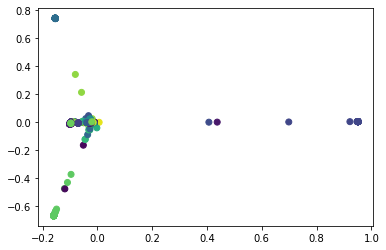

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pred_pca = pca.fit_transform(predtest)
labels = data.testlabels

plt.scatter(pred_pca[:,0], pred_pca[:,1], c=labels)

## Classifying the embeddings to classes using a dense network

In [ ]:
def getClassifier():
    input_shape = (49)
    inputs = layers.Input(shape=input_shape)

    layer2 = layers.Dense(49)(inputs)
    outputs = layers.Activation('softmax')(layer2)
    # Compile the model

    model_classifier = Model(inputs=inputs, outputs=outputs)
    model_classifier.compile(
        optimizer=Adam(0.1),
        loss='CategoricalCrossentropy')
    return model_classifier
    
classifier = getClassifier()
classifier.summary()
# immediately train:
history = classifier.fit(predtrain,train_out, \
    batch_size=3000, \
    epochs=150, \
    validation_data=(predval, val_out), \
    shuffle=True, verbose=1)
print(history.history['loss'][-1])
print(history.history['val_loss'][-1])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 49)]              0         
                                                                 
 dense (Dense)               (None, 49)                2450      
                                                                 
 activation_88 (Activation)  (None, 49)                0         
                                                                 
Total params: 2,450
Trainable params: 2,450
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
1/1 [==============================] - 0s 382ms/step - loss: 3.8941 - val_loss: 3.6981
Epoch 2/150
1/1 [==============================] - 0s 28ms/step - loss: 3.6624 - val_loss: 3.4966
Epoch 3/150
1/1 [==============================] - 0s 32ms/step - loss: 3.4400 - val_loss: 3.3045
Epoch 4/150
1/1 [=========

In [ ]:
outtest = classifier(predtest)
mypred = np.argmax(outtest, axis=1)
np.sum(mypred == data.testlabels) / mypred.size

0.9305263157894736